# extract features using whisper + bert

## Setup

In [58]:
import os
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
#VAL_SIZE = 0.2 
DATA_DIR = "data/" 
#SUB_DIR = "submission"

## Load data

In [102]:
# load preprocessed data
train = pd.read_csv(os.path.join(DATA_DIR, "transcripts/transcript_train_audios_small_v2.csv"),index_col=0)
train_y = pd.read_csv(os.path.join(DATA_DIR, "original/train_labels.csv"),index_col=0)
#test = pd.read_csv(os.path.join(DATA_DIR, "transcripts/transcript_test_audios_small_v0.csv"),index_col=0)
#ss = pd.read_csv(os.path.join(DATA_DIR, "original/submission_format.csv"),index_col=0)
metadata = pd.read_csv(os.path.join(DATA_DIR, "original/metadata.csv"),index_col=0)
metadata = metadata[["gender", "age"]]
metadata['gender'] = metadata['gender'].replace({'male': 0, 'female': 1})
train.index.name = "uid"
#test.index.name = "uid"
train = train.loc[train_y.index]

train = train.merge(metadata, on="uid", how="left")
#test = test.merge(metadata, on="uid", how="left")
#train.shape, test.shape
train.shape

/var/folders/8c/1hmyksxs6lj28w7qfrdcd8900000gn/T/ipykernel_64338/2504665318.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metadata['gender'] = metadata['gender'].replace({'male': 0, 'female': 1})


(1646, 5)

In [103]:
train.head()

,transcription,language,confidence,gender,age
uid,,,,,
aaop,"Alexa,[WORD PAUSE: 0.3s] what time is it?[SEN...",en,0.991422,1,72
abgk,"Well,[WORD PAUSE: 0.1s] the mother's washing ...",en,0.998720,0,80
ablf,"Oh,[WORD PAUSE: 0.2s] well,[WORD PAUSE: 0.3s]...",en,0.995016,0,64
acad,A mucho tiempo que vivía un hidalgo de los de...,es,0.868240,1,76
acis,"En un lugar de la mancha,[WORD PAUSE: 0.1s] d...",es,0.942708,1,87


In [104]:
train.groupby(['language']).count()

,transcription,confidence,gender,age
language,,,,
en,1325,1332,1332,1332
es,209,210,210,210
gl,69,70,70,70
la,1,1,1,1
zh,32,33,33,33


In [105]:
train['transcription'] = train['transcription'].astype(str)

In [106]:
# add language as a covariate 
language_one_hot = pd.get_dummies(train[['language']], columns=['language']).astype(int)
train = train.merge(language_one_hot, on="uid", how="left")
#language_one_hot = pd.get_dummies(train[['langage']], columns=['langage']).astype(int)
#test = test.merge(language_one_hot, on="uid", how="left")

In [107]:
train.head()

,transcription,language,confidence,gender,age,language_en,language_es,language_gl,language_la,language_zh
uid,,,,,,,,,,
aaop,"Alexa,[WORD PAUSE: 0.3s] what time is it?[SEN...",en,0.991422,1,72,1,0,0,0,0
abgk,"Well,[WORD PAUSE: 0.1s] the mother's washing ...",en,0.998720,0,80,1,0,0,0,0
ablf,"Oh,[WORD PAUSE: 0.2s] well,[WORD PAUSE: 0.3s]...",en,0.995016,0,64,1,0,0,0,0
acad,A mucho tiempo que vivía un hidalgo de los de...,es,0.868240,1,76,0,1,0,0,0
acis,"En un lugar de la mancha,[WORD PAUSE: 0.1s] d...",es,0.942708,1,87,0,1,0,0,0


In [108]:
# exclude minority languages
train['exclude'] = (train['language_la'] + train['language_zh']) > 0
include_samples = train[train['exclude']==0].index.unique().tolist()
print(len(include_samples))

# Exclude minority languages that do not belong to training 
train_y = train_y.loc[include_samples]
train = train.loc[train_y.index]
train.drop(['language_la', 'language_zh', 'exclude'],axis=1, inplace=True)
train_y.shape, train.shape

1612


((1612, 3), (1612, 8))

In [109]:
train_y

,diagnosis_control,diagnosis_mci,diagnosis_adrd
uid,,,
aaop,0.0,1.0,0.0
abgk,1.0,0.0,0.0
ablf,1.0,0.0,0.0
acad,1.0,0.0,0.0
acis,0.0,1.0,0.0
...,...,...,...
zxgq,1.0,0.0,0.0
zxtj,1.0,0.0,0.0
zyps,0.0,1.0,0.0


In [110]:
train

,transcription,language,confidence,gender,age,language_en,language_es,language_gl
uid,,,,,,,,
aaop,"Alexa,[WORD PAUSE: 0.3s] what time is it?[SEN...",en,0.991422,1,72,1,0,0
abgk,"Well,[WORD PAUSE: 0.1s] the mother's washing ...",en,0.998720,0,80,1,0,0
ablf,"Oh,[WORD PAUSE: 0.2s] well,[WORD PAUSE: 0.3s]...",en,0.995016,0,64,1,0,0
acad,A mucho tiempo que vivía un hidalgo de los de...,es,0.868240,1,76,0,1,0
acis,"En un lugar de la mancha,[WORD PAUSE: 0.1s] d...",es,0.942708,1,87,0,1,0
...,...,...,...,...,...,...,...,...
zxgq,"who is reaching inside of a jar,[WORD PAUSE: ...",en,0.997171,1,82,1,0,0
zxtj,"Okay,[WORD PAUSE: 0.3s] the boy is up in the ...",en,0.999304,1,58,1,0,0
zyps,about fall over.[WORD PAUSE: 0.3s] And the mo...,en,0.999651,1,91,1,0,0


In [111]:
train.reset_index(inplace=True)
idx_en = train[train['language']=='en'].index
idx_other = train[train['language']!='en'].index
len(idx_en), len(idx_other)

(1332, 280)

## Preprocessing

### compare pause length among AD, MCI, and NON-AD groups <br/>
observations <br/>
* for the same group, sentence pause is longer on average compared to word pause

In [112]:
# create df for each subgroup
ad_uids = train_y[train_y['diagnosis_adrd'] == 1].index.unique().tolist()
mci_uids = train_y[train_y['diagnosis_mci'] == 1].index.unique().tolist()
control_uids = train_y[train_y['diagnosis_control'] == 1].index.unique().tolist()

train_ad = train[train['uid'].isin(ad_uids)]
train_mci = train[train['uid'].isin(mci_uids)]
train_control= train[train['uid'].isin(control_uids)]

train_ad

,uid,transcription,language,confidence,gender,age,language_en,language_es,language_gl
5,acqd,k now i've got something here for you like yo...,en,0.993105,1,80,1,0,0
15,aikf,action that you see in the shot.[SENTENCE PAU...,en,0.991877,1,67,1,0,0
18,akni,"Well,[WORD PAUSE: 0.1s] the kids are swiping ...",en,0.998511,1,75,1,0,0
19,akqh,"Wow,[WORD PAUSE: 0.2s] into the cookie jar in...",en,0.998762,1,73,1,0,0
20,allm,The little boy is getting in the cookie jar.[...,en,0.999463,1,66,1,0,0
...,...,...,...,...,...,...,...,...,...
1591,zpir,What's going on in the picture?[SENTENCE PAUS...,en,0.999301,1,71,1,0,0
1594,zriz,"If some other cleaning the dishes,[WORD PAUSE...",en,0.991348,0,81,1,0,0
1597,zsbf,I'll tell you what's going on in the picture....,en,0.977365,1,74,1,0,0
1602,zvhj,"I mean,[WORD PAUSE: 0.3s] what I see,[WORD PA...",en,0.996510,0,80,1,0,0


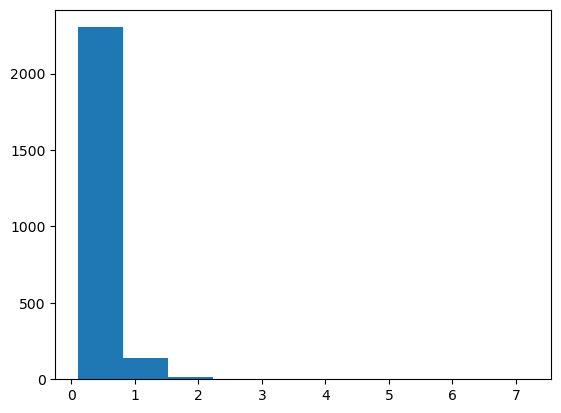

count    2460.000000
mean        0.368415
std         0.331764
min         0.100000
25%         0.200000
50%         0.300000
75%         0.400000
max         7.200000
dtype: float64

In [62]:
## extract pause timem - ad group: word pause
plt.hist(train_ad['transcription'].str.extractall(r'\[WORD PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist())
plt.show()

pd.Series(train_ad['transcription'].str.extractall(r'\[WORD PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist()).describe()

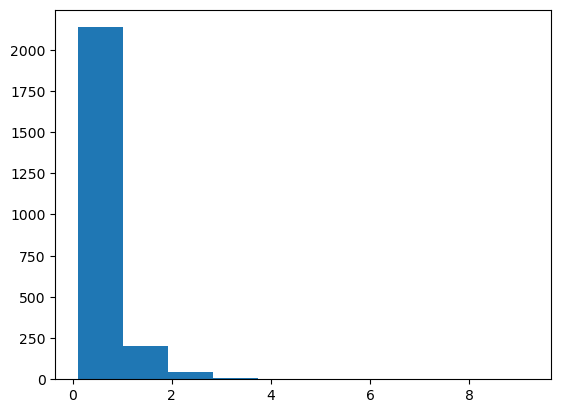

count    2398.000000
mean        0.569516
std         0.547891
min         0.100000
25%         0.300000
50%         0.400000
75%         0.700000
max         9.200000
dtype: float64

In [63]:
## extract pause timem - ad group: sentence pause
plt.hist(train_ad['transcription'].str.extractall(r'\[SENTENCE PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist())
plt.show()

pd.Series(train_ad['transcription'].str.extractall(r'\[SENTENCE PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist()).describe()

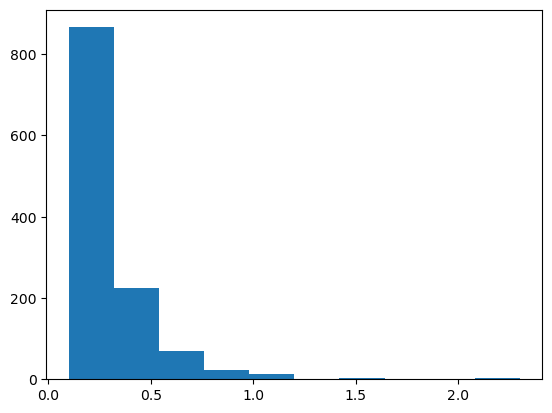

count    1202.000000
mean        0.307321
std         0.212035
min         0.100000
25%         0.200000
50%         0.300000
75%         0.400000
max         2.300000
dtype: float64

In [64]:
## extract pause time - mci group: word pause
plt.hist(train_mci['transcription'].str.extractall(r'\[WORD PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist())
plt.show()

pd.Series(train_mci['transcription'].str.extractall(r'\[WORD PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist()).describe()

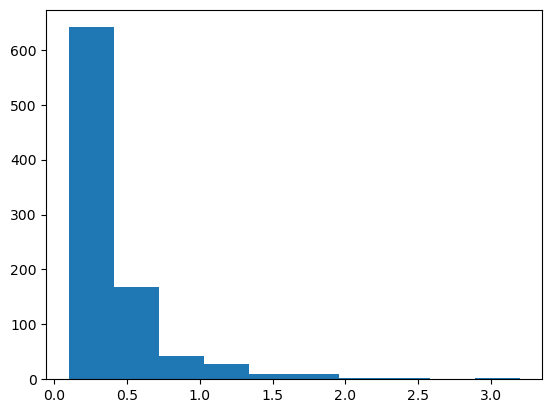

count    906.000000
mean       0.421523
std        0.351336
min        0.100000
25%        0.200000
50%        0.300000
75%        0.500000
max        3.200000
dtype: float64

In [65]:
## extract pause time - mci group: sentence pause
plt.hist(train_mci['transcription'].str.extractall(r'\[SENTENCE PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist())
plt.show()

pd.Series(train_mci['transcription'].str.extractall(r'\[SENTENCE PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist()).describe()

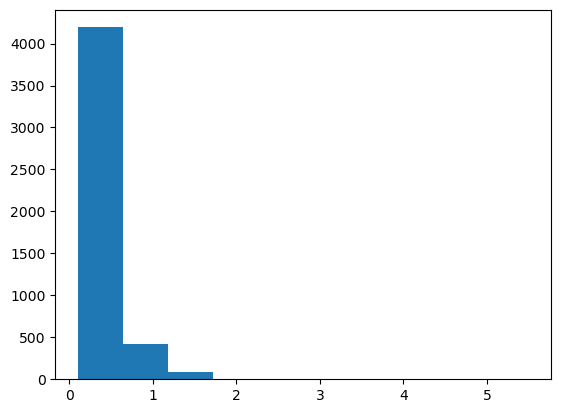

count    4709.000000
mean        0.360310
std         0.275883
min         0.100000
25%         0.200000
50%         0.300000
75%         0.400000
max         5.500000
dtype: float64

In [66]:
## extract pause time - control group: word pause
plt.hist(train_control['transcription'].str.extractall(r'\[WORD PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist())
plt.show()

pd.Series(train_control['transcription'].str.extractall(r'\[WORD PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist()).describe()

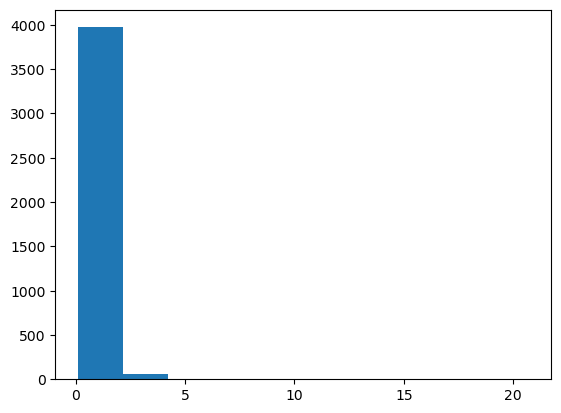

count    4034.000000
mean        0.545216
std         0.611310
min         0.100000
25%         0.200000
50%         0.400000
75%         0.700000
max        20.700000
dtype: float64

In [67]:
## extract pause time - control group: sentence pause
plt.hist(train_control['transcription'].str.extractall(r'\[SENTENCE PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist())
plt.show()

pd.Series(train_control['transcription'].str.extractall(r'\[SENTENCE PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist()).describe()

In [75]:
# merge pause: ad
train_ad_pause = train_ad['transcription'].str.extractall(r'\[SENTENCE PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist()
train_ad_pause.extend(train_ad['transcription'].str.extractall(r'\[WORD PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist())
pd.Series(train_ad_pause).describe()

count    4858.000000
mean        0.467682
std         0.462581
min         0.100000
25%         0.200000
50%         0.300000
75%         0.600000
max         9.200000
dtype: float64

In [76]:
# merge pause: mci
train_mci_pause = train_mci['transcription'].str.extractall(r'\[SENTENCE PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist()
train_mci_pause.extend(train_mci['transcription'].str.extractall(r'\[WORD PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist())
pd.Series(train_mci_pause).describe()

count    2108.000000
mean        0.356404
std         0.286082
min         0.100000
25%         0.200000
50%         0.300000
75%         0.400000
max         3.200000
dtype: float64

In [77]:
# merge pause: control
train_control_pause = train_control['transcription'].str.extractall(r'\[SENTENCE PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist()
train_control_pause.extend(train_control['transcription'].str.extractall(r'\[WORD PAUSE:\s([\d.]+)s\]')[0].astype(float).tolist())
pd.Series(train_control_pause).describe()

count    8743.000000
mean        0.445625
std         0.471051
min         0.100000
25%         0.200000
50%         0.300000
75%         0.500000
max        20.700000
dtype: float64

### step 1 formatting: remove punctuation + lower case

In [113]:
train

,uid,transcription,language,confidence,gender,age,language_en,language_es,language_gl
0,aaop,"Alexa,[WORD PAUSE: 0.3s] what time is it?[SEN...",en,0.991422,1,72,1,0,0
1,abgk,"Well,[WORD PAUSE: 0.1s] the mother's washing ...",en,0.998720,0,80,1,0,0
2,ablf,"Oh,[WORD PAUSE: 0.2s] well,[WORD PAUSE: 0.3s]...",en,0.995016,0,64,1,0,0
3,acad,A mucho tiempo que vivía un hidalgo de los de...,es,0.868240,1,76,0,1,0
4,acis,"En un lugar de la mancha,[WORD PAUSE: 0.1s] d...",es,0.942708,1,87,0,1,0
...,...,...,...,...,...,...,...,...,...
1607,zxgq,"who is reaching inside of a jar,[WORD PAUSE: ...",en,0.997171,1,82,1,0,0
1608,zxtj,"Okay,[WORD PAUSE: 0.3s] the boy is up in the ...",en,0.999304,1,58,1,0,0
1609,zyps,about fall over.[WORD PAUSE: 0.3s] And the mo...,en,0.999651,1,91,1,0,0
1610,zytb,"jam,[WORD PAUSE: 1.0s] dish towel,[WORD PAUSE...",en,0.996715,0,81,1,0,0


In [114]:
import string 
import re 

# table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
# string_punctuation_1 = string.punctuation.replace(".","").replace("`","").replace("'","")
# table_ = str.maketrans(string_punctuation_1, ' '*len(string_punctuation_1))
# printable = set(string.printable)

# def clean_data(text):
#     """
#     clean data: lower case, remove space
#     """
#     sentence = text.lower()
#     sentence_no_punct = sentence.translate(table_)
#     space_remove = re.sub('\s+',' ', sentence_no_punct)
#     return space_remove


In [115]:
# Function to process text
def process_data(text):
    # Define a regex pattern for [PAUSE: ...]
    pattern = r'\[.*?PAUSE: [^\]]+\]'
    
    # Find all pause annotations
    pauses = re.findall(pattern, text)
    
    # Replace all pause annotations with placeholders
    text_with_placeholders = re.sub(pattern, "PAUSE_PLACEHOLDER", text)
    
    # Process text outside pauses
    processed = re.sub(r'[^\w\s]', '', text_with_placeholders).lower()
    
    # Restore pause annotations
    for pause in pauses:
        processed = processed.replace("pause_placeholder", pause, 1)
    
    return processed

In [117]:
train['transcription'] = train['transcription'].apply(lambda x : process_data(x))

In [118]:
train['transcription']

0        alexa[WORD PAUSE: 0.3s] what time is it[SENTE...
1        well[WORD PAUSE: 0.1s] the mothers washing di...
2        oh[WORD PAUSE: 0.2s] well[WORD PAUSE: 0.3s] t...
3        a mucho tiempo que vivía un hidalgo de los de...
4        en un lugar de la mancha[WORD PAUSE: 0.1s] de...
                              ...                        
1607     who is reaching inside of a jar[WORD PAUSE: 0...
1608     okay[WORD PAUSE: 0.3s] the boy is up in the c...
1609     about fall over[WORD PAUSE: 0.3s] and the mot...
1610     jam[WORD PAUSE: 1.0s] dish towel[WORD PAUSE: ...
1611     please take a look at this picture and descri...
Name: transcription, Length: 1612, dtype: object

### step 2: replace pause with punctuation based on pre-defined threshold

approach following this paper: Disfluencies and Fine-Tuning Pre-trained Language Models for Detection of Alzheimer’s Disease by Yuan et al.

In [119]:
def replace_pauses(text):
    # Define a regex pattern for [WORD PAUSE: ...] or [SENTENCE PAUSE: ...]
    pattern = r'\[.*?PAUSE: ([\d.]+)s\]'
    
    # Function to determine the replacement based on pause duration
    def replacement(match):
        pause_duration = float(match.group(1))
        if pause_duration < 0.5:
            return ','
        elif 0.5 <= pause_duration <= 2:
            return '.'
        elif pause_duration>=10: # remove those very long pause
            return '><'
        else:
            return '...'
    
    # Replace pauses in the text
    processed_text = re.sub(pattern, replacement, text)
    return processed_text

In [121]:
train['transcription'] = train['transcription'].apply(lambda x : replace_pauses(x))

In [128]:
replace_pauses("hello [WORD PAUSE: 15s]")

'hello ><'

In [122]:
train['transcription']

0        alexa, what time is it. alexa, when is thanks...
1        well, the mothers washing dishes and the wate...
2        oh, well, the sinks overflowing with all the ...
3        a mucho tiempo que vivía un hidalgo de los de...
4        en un lugar de la mancha, de cuyo nombre no q...
                              ...                        
1607     who is reaching inside of a jar. a copper sto...
1608     okay, the boy is up in the cupboard getting c...
1609     about fall over, and the mother is washing di...
1610     jam. dish towel, water, falls. wet floor, pat...
1611     please take a look at this picture and descri...
Name: transcription, Length: 1612, dtype: object

### step 3: remove low-quality samples due to at least one of the following
* too short (less than 20 words)

In [124]:
train[train['transcription'].apply(lambda x: len(x.split())<=20)]

,uid,transcription,language,confidence,gender,age,language_en,language_es,language_gl
28,anek,i dont know i dont know i dont know. now. dow...,en,0.957522,1,80,1,0,0
37,apps,go ask in capital took to machine that says s...,en,0.884970,1,81,1,0,0
89,bpdx,and then stands the,en,0.875009,1,70,1,0,0
105,bxkp,thank you,en,0.684403,0,83,1,0,0
115,ccpw,tell me what you see there,en,0.963788,0,82,1,0,0
140,cqff,"well, thank you so much for watching. well se...",en,0.964094,1,79,1,0,0
151,cubn,"i see a young boy falling off a stool, steali...",en,0.998355,0,68,1,0,0
214,dxpr,nan,en,0.936464,0,67,1,0,0
268,exeb,en conos an paste de tuya nombre non quera ac...,gl,0.845445,1,87,0,0,1
292,fgtd,nan,en,0.908756,1,66,1,0,0


* pause too long

In [130]:
train[train['transcription'].str.contains('><')]

,uid,transcription,language,confidence,gender,age,language_en,language_es,language_gl
879,olwg,this house or whatever yeah>< other drying di...,en,0.983035,0,56,1,0,0
1578,zkqs,and wings. then makeioso>< whom. app,en,0.775817,0,83,1,0,0


## Linguistic Feature Extraction

WavBERT: https://github.com/billzyx/WavBERT

* basic WavBERT: extracting semantic information from speech data using Wav2vec, and analyzing the semantic information using BERT -> use our transcript
* extended WavBERT: convert the output ofWav2vec to the input to BERT for preserving the non-semantic information in dementia detection -> add sentence level pause

### whisper + BERT

original bert
* WavBERT [16] utilizes speech pauses and transcripts for dementia detection. It transcribes the speech audio to transcript using Wav2vec, and this transcript does not have punctuation marks. WavBERT uses the number of blank tokens from the intermediate results of Wav2vec to define two levels of pauses: longer sentence-level pause and shorter insentence pause. A “period” mark is inserted into the transcript if a sentence-level pause is determined; a “comma” mark is inserted into the transcript if an in-sentence pause is determined. After adding the punctuation “period” and “comma” into the transcripts, WavBERT feeds the transcripts to BERT for AD classification. More details can be found in Figure 1 and the paper [16]. In this paper, we add one more level of in-sentence pause and represent it with “semicolon.” The length of such pause is longer than “comma” and shorter than “period.” <br/>
source: https://pmc.ncbi.nlm.nih.gov/articles/PMC10102974/ <br/>
another paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC7845557/ 

our approach
* use whisper to transcribe and annotate both sentence-level pause and word-level pause
* make transcript lower case and remove any punctuation using `process_data(text)`
* convert sentence-level and word-level pauses with ',' '.' '...' using `replace_pauses(text)`